In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np
from collections import defaultdict

# Some useful utilities

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=len(v))

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def z_clip(xs, b):
    return [min(x, b) for x in xs]

def g_clip(v):
    n = np.linalg.norm(v, ord=2)
    if n > 1:
        return v / n
    else:
        return v

# Machine Learning

```{admonition} Learning Objectives
After reading this chapter, you will be able to:
- Describe and implement the basic algorithm for gradient descent
- Use the Gaussian mechanism to implement differentially private gradient descent
- Clip gradients to enforce differential privacy for arbitrary loss functions
- Describe the effect of noise on the training process
```

In this chapter, we're going to explore building differentially private machine learning classifiers. We'll focus on a kind of *supervised learning* problem: given a set of *labeled training examples* $\{(x_1, y_1), \dots, (x_n, y_n)\}$, in which $x_i$ is called the *feature vector* and $y_i$ is called the *label*, train a *model* $\theta$ which can *predict* the label for a new feature vector which was not present in the training set. Each $x_i$ is typically a vector of real numbers which describe the features of a training example, and the $y_i$s are drawn from a predefined set of *classes* (usually expressed as integers) that examples can be drawn from. A *binary* classifier has two classes (usually either 1 and 0, or 1 and -1).

## Logistic Regression with Scikit-Learn

The dataset files you'll need are available here:

- [`adult_processed_x`](https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_processed_x.npy)
- [`adult_processed_y`](https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_processed_y.npy)

In [2]:
X = np.load('adult_processed_x.npy')
y = np.load('adult_processed_y.npy')

To train a model, we will use some of the data we have available to build a set of *training examples* (as described earlier), but we'll also set aside some of the data as *test examples*. Once we have trained the model, we want to know how well it works on examples that are *not* present in the training set. A model which works well on new examples it hasn't seen before is said to *generalize* well. One which does *not* generalize well is said to have *overfitted* the training data.

To test generalization, we'll use the test examples - we have labels for
them, so we can test the generalization accuracy of the model by asking
the model to classify each one, and then comparing the predicted class
against the actual label from our dataset. We'll split our data into a
training set containing 80% of the examples, and a testing set containing
20% of the examples.

In [3]:
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

y_test.shape

(9044,)

A simple way to build a binary classifier is with *logistic regression*. The scikit-learn library has a built-in module for performing logistic regression, called `LogisticRegression`, and it's easy to use to build a model using our data.

In [4]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train[:1000],y_train[:1000])
model

LogisticRegression()

Next, we can use the model's `predict` method to predict labels for the test set.

In [5]:
model.predict(X_test)

array([-1., -1., -1., ..., -1., -1., -1.])

So, how many test examples does our model get correct? We can compare the
predicted labels against the actual labels from the dataset; if we divide
the number of correctly predicted labels by the total number of test
examples, we can measure the percent of the examples which are correctly
classified.

In [6]:
np.sum(model.predict(X_test) == y_test)/X_test.shape[0]

0.8243034055727554

 Our model predicts the correct label for 82% of the examples in our test
set. For this dataset, that's a pretty decent result.

## What is a Model?

What exactly *is* a model? How does it encode the information it uses to make predictions?

There are many different kinds of models, but the ones we'll explore here are *linear models*. For an unlabeled example with a $k$-dimensional feature vector $x_1, \dots, x_k$, a linear model predicts a label by first calculating the quantity:

\begin{align}
w_1 x_1 + \dots + w_k x_k + bias
\end{align}

and then taking the sign of it (i.e. if the quantity above is negative, we predict the label -1; if it's positive, we predict 1).

The model itself, then, can be represented by a vector containing the values $w_1, \dots, w_k$ and the value for $bias$. The model is said to be linear because the quantity we calculate in predicting a label is a polynomial of degree 1 (i.e. linear). The values $w_1, \dots, w_k$ are often called the *weights* or *coefficients* of the model, and $bias$ is often called the *bias term* or *intercept*.

This is actually how scikit-learn represents its logistic regression model, too! We can check out the weights of our trained model using the `coef_` attribute of the model:

In [7]:
model.intercept_[0], model.coef_[0]

(-5.346167750306461,
 array([ 3.76035057e-01, -2.55358856e-01, -3.21341426e-02,  3.74545737e-01,
        -6.85885223e-01,  3.91875239e-01, -1.69476241e-01, -7.41793527e-02,
        -5.76496538e-01,  3.94976503e-01, -3.41457312e-01, -6.24912317e-01,
        -6.05605602e-01, -4.56928100e-01, -5.19167009e-01, -1.05743009e-01,
         8.19586633e-01,  9.96762702e-01, -3.09342985e-01,  6.57277160e-01,
        -1.06436104e-01,  7.71287796e-01,  7.99791034e-02,  1.43803702e-01,
        -1.01006564e-01,  1.59416785e+00, -5.06233997e-02, -5.78477239e-01,
        -3.72601413e-01, -6.35661364e-01, -1.02810175e-01,  0.00000000e+00,
        -1.35478173e-01,  4.36864993e-01, -3.42554362e-01, -1.32819675e-01,
        -2.00200285e-01, -1.53919241e+00,  6.44831702e-02,  7.17836796e-01,
         3.80039408e-01,  4.25898498e-02,  8.81653483e-01, -7.08110462e-02,
         6.10385977e-02,  8.94590966e-02,  6.93679716e-01, -1.30382712e+00,
        -6.55878656e-01,  1.11512993e+00,  3.78012650e-01, -4.28231

Note that we'll always have exactly the same number of weights $w_i$ as we have features $x_i$, since we have to multiply each feature by its corresponding weight. That means our model has exactly the same dimensionality as our feature vectors.

Now that we have a way to get the weights and bias term, we can implement our own function to perform prediction:

In [8]:
# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

np.sum(predict(X_test, model.coef_[0], model.intercept_[0]) == y_test)/X_test.shape[0]

0.8243034055727554

We've made the bias term optional here, because in many cases it's possible to do just as well without it. To make things simpler, we won't bother to train a bias term in our own algorithm.

## Training a Model with Gradient Descent

How does the training process actually work? The scikit-learn library has some pretty sophisticated algorithms, but we can do just about as well by implementing a simple one called *gradient descent*. 

Most training algorithms for machine learning are defined in terms of a *loss function*, which specifies a way to measure how "bad" a model is at prediction. The goal of the training algorithm is to minimize the output of the loss function - a model with low loss will be *good* at prediction. 

The machine learning community has developed many different commonly-used loss functions. A simple loss function might return 0 for each correctly predicted example, and 1 for each incorrectly predicted example; when the loss becomes 0, that means we've predicted each example's label correctly. A more commonly used loss function for binary classification is called the *logistic loss*; the logistic loss gives us a measure of "how far" we are from predicting the correct label (which is more informative than the simple 0 vs 1 approach).

The logistic loss is implemented by the following Python function:

In [9]:
# The loss function measures how good our model is. The training goal is to minimize the loss.
# This is the logistic loss function.
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

We can use the loss function to measure how good a particular model is. Let's try it out with a model whose weights are all zeros. This model isn't likely to work very well, but it's a starting point from which we can train a better one.

In [10]:
theta = np.zeros(X_train.shape[1])
loss(theta, X_train[0], y_train[0])

0.6931471805599453

We typically measure how good our model is over our entire training set by simply averaging the loss over all of the examples in the training data. In this case, we get *every* example wrong, so the average loss on the whole training set is exactly equal to the loss we calculated above for just one example.

In [11]:
np.mean([loss(theta, x_i, y_i) for x_i, y_i in zip(X_train, y_train)])

0.6931471805599453

Our goal in *training* the model is to *minimize* the loss. So the key question is: how do we modify the model to make the loss smaller? 

Gradient descent is an approach that makes the loss smaller by updating the model according to the [*gradient*](https://en.wikipedia.org/wiki/Gradient) of the loss. The gradient is like a multi-dimensional derivative: for a function with multi-dimensional inputs (like our loss function above), the gradient tells you how fast the function's output is changing with respect to *each* dimension of the input. If the gradient is positive in a particular dimension, that means the function's value will *increase* if we increase the model's weight for that dimension; we want the loss to *decrease*, so we should modify our model by *negating* the gradient - i.e. do the *opposite* of what the gradient says. Since we move the model in the opposite direction of the gradient, this is called *descending* the gradient.

When we iteratively perform many steps of this descent process, we slowly get closer and closer to the model which minimizes the loss. This algorithm is called *gradient descent*. Let's see how this looks in Python; first, we'll define the gradient function.

In [12]:
# This is the gradient of the logistic loss
# The gradient is a vector that indicates the rate of change of the loss in each direction
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

### A Single Step of Gradient Descent

Next, let's perform a single step of gradient descent. We can apply the `gradient` function to a single example from our training data, which should give us enough information to improve the model for that example. We "descend" the gradient by subtracting it from our current model `theta`.

In [13]:
# If we take a step in the *opposite* direction from the gradient (by negating it), we should 
# move theta in a direction that makes the loss *lower*
# This is one step of gradient descent - in each step, we're trying to "descend" the gradient
# In this example, we're taking the gradient on just a single training example (the first one)
theta = theta - gradient(theta, X_train[0], y_train[0])
theta

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        ,  0.        ,  0.        , -0.5       ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.5       ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.5       ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        , -0.5       ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

Now, if we call `predict` on the same example from the training data, its label is predicted correctly! That means our update did indeed improve the model, since it's now capable of classifying this example.

In [14]:
y_train[0], predict(theta, X_train[0])

(-1.0, -1.0)

We'll be measuring the accuracy of our model many times, so let's define a helper function for measuring accuracy. It works in the same way as the accuracy measurement for the sklearn model above. We can use it on the `theta` we've built by descending the gradient for one example, to see how good our model is on the test set.

In [15]:
def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

accuracy(theta)

0.7585139318885449

Our improved model now predicts 75% of the labels for the test set correctly! That's good progress - we've improved the model considerably.

### A Gradient Descent Algorithm

We need to make two changes to arrive at a basic gradient descent algorithm. First, our single step above used only a single example from the training data; we want to consider the *whole* training set when updating the model, so that we improve the model for *all* examples. Second, we need to perform multiple iterations, to get as close as possible to minimizing the loss.

We can solve the first problem by calculating the *average gradient* over all of the training examples, and using it for the descent step in place of the single-example gradient we used before. Our `avg_grad` function calculates the average gradient over a whole array of training examples and the corresponding labels.

In [16]:
def avg_grad(theta, X, y):
    grads = [gradient(theta, xi, yi) for xi, yi in zip(X, y)]
    return np.mean(grads, axis=0)

avg_grad(theta, X_train, y_train)

array([-8.03202480e-03, -1.09365062e-02, -5.86649848e-02, -1.70297784e-02,
       -1.85949049e-02, -5.32762100e-03,  3.15432083e-05,  2.24692568e-03,
        1.80942171e-03,  1.10891317e-03,  7.17940863e-04,  1.22012681e-03,
        1.09385854e-03,  1.42352970e-03, -4.29266203e-03, -5.73114012e-03,
       -4.96409990e-02, -7.90844879e-03, -1.08970068e-02, -2.50609905e-02,
        3.27410319e-04, -1.20102580e-02, -1.29608985e-02,  1.15182321e-02,
       -2.26895536e-04, -1.83255483e-01,  1.34642262e-03,  4.47703452e-02,
        4.31895523e-03,  2.97414610e-03,  6.16295082e-03, -4.88903955e-05,
       -2.13933205e-02, -4.86969833e-02, -8.62802483e-04,  3.11463168e-03,
        1.23013848e-03,  1.54486498e-02,  1.21336873e-03, -4.38864985e-02,
       -4.34689131e-03, -1.64743409e-02, -4.53583200e-03, -5.47845717e-03,
       -1.67472715e-01,  1.93015718e-02,  4.73608091e-03,  2.44149704e-02,
        1.61917788e-02, -1.57259641e-02,  6.59058497e-04, -1.58429762e-03,
        9.21938268e-03,  

To solve the second problem, we'll define an iterative algorithm that descends the gradient multiple times.

In [17]:
def gradient_descent(iterations):
    # Start by "guessing" what the model should be (all zeros)
    theta = np.zeros(X_train.shape[1])

    # Perform `iterations` steps of gradient descent using training data
    for i in range(iterations):
        theta = theta - avg_grad(theta, X_train, y_train)

    return theta

In [18]:
theta = gradient_descent(10)
accuracy(theta)

0.7787483414418399

After 10 iterations, our model reaches nearly 78% accuracy - not bad! Our gradient descent algorithm looks simple (and it is!) but don't let its simplicity fool you - this basic approach is behind many of the recent successes in large-scale deep learning, and our algorithm is *very* close in its design to the ones implemented in popular frameworks for machine learning like TensorFlow.

Notice that we didn't quite make it to the 84% accuracy of the sklearn model we trained earlier. Don't worry - our algorithm is definitely capable of this! We just need more iterations, to get closer to the minimum of the loss.

With 100 iterations, we get closer - 82% accuracy. However, the algorithm takes a long time to run when we ask for so many iterations. Even worse, the closer we get to minimizing the loss, the more difficult it is to improve - so we might get to 82% accuracy after 100 iterations, but it might take 1000 iterations to get to 84%. This points to a fundamental tension in machine learning - generally speaking, more iterations of training can improve accuracy, but more iterations requires more computation time. Most of the "tricks" used to make large-scale deep learning practical are actually aimed at speeding up each iteration of gradient descent, so that more iterations can be performed in the same amount of time.

One more thing that's interesting to note: the value of the loss function does indeed go down with each iteration of gradient descent we perform - so as we perform more iterations, we slowly get closer to minimizing the loss. Also note that the training and testing loss are very close to one another, suggesting that our model is not *overfitting* to the training data.

In [19]:
def gradient_descent_log(iterations):
    theta = np.zeros(X_train.shape[1])

    for i in range(iterations):
        theta = theta - avg_grad(theta, X_train, y_train)
        print(f'Training loss: {np.mean(loss(theta, X_train, y_train))}')
        print(f'Testing loss: {np.mean(loss(theta, X_test, y_test))}\n')

    return theta

gradient_descent_log(5);

Training loss: 0.549109439168421
Testing loss: 0.5415350837580458

Training loss: 0.5224689105514977
Testing loss: 0.5162665121068426

Training loss: 0.5028090736020403
Testing loss: 0.49753785424732383

Training loss: 0.4878874803989895
Testing loss: 0.48335633696635527

Training loss: 0.47628573924997925
Testing loss: 0.4723742456095848



## Gradient Descent with Differential Privacy

How can we make the above algorithm differentially private? We'd like to design an algorithm that ensures differential privacy for the training data, so that the final model doesn't reveal anything about individual training examples.

The only part of the algorithm which uses the training data is the gradient calculation. One way to make the algorithm differentially private is to add noise to the gradient itself at each iteration before updating the model. This approach is usually called *noisy gradient descent*, since we add noise directly to the gradient.

Our gradient function is a vector-valued function, so we can use `gaussian_mech_vec` to add noise to its output:

In [20]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = '???'

    for i in range(iterations):
        grad = avg_grad(theta, X_train, y_train)
        noisy_grad = gaussian_mech_vec(grad, sensitivity, epsilon, delta)
        theta = theta - noisy_grad

    return theta

There's just one piece of the puzzle missing - **what is the sensitivity of the gradient function**? Answering this question is the central difficulty in making the algorithm work.

There are two major challenges here. First, the gradient is the result of an *average query* - it's the mean of many per-example gradients. As we've seen previously, it's best to split queries like this up into a sum query and a count query. This isn't difficult to do - we can compute the noisy sum of the per-example gradients, rather than their average, and divide by a noisy count later. Second, we need to bound the sensitivity of each per-example gradient. There are two basic approaches for this: we can either analyze the gradient function itself (as we have done with previous queries) to determine its worst-case global sensitivity, or we can *enforce* a sensitivity by clipping the output of the gradient function (as we did in sample and aggregate).

We'll start with the second approach - often called *gradient clipping* - because it's simpler conceptually and more general in its applications.

### Gradient Clipping

Recall that when we implemented sample and aggregate, we enforced a desired sensitivity on a function $f$ with unknown sensitivity by clipping its output. The sensitivity of $f$ was:

\begin{align}
\lvert f(x) - f(x') \rvert
\end{align}

After clipping with parameter $b$, this becomes:

\begin{align}
\lvert \mathsf{clip}(f(x), b) - \mathsf{clip}(f(x'),b) \rvert
\end{align}

In the worst case, $\mathsf{clip}(f(x), b) = b$, and $\mathsf{clip}(f(x'),b) = 0$, so the sensitivity of the clipped result is exactly $b$ (the value of the clipping parameter).

We can use the same trick to bound the $L2$ sensitivity of our gradient function. We'll need to define a function which "clips" a vector so that it has $L2$ norm within a desired range. We can accomplish this by *scaling* the vector: if we divide the vector elementwise by its $L2$ norm, then the resulting vector will have an $L2$ norm of 1. If we want to target a particular clipping parameter $b$, we can multiply the scaled vector by $b$ to scale it back up to have $L2$ norm $b$. We want to avoid modifying vectors that already have $L2$ norm below $b$; in that case, we just return the original vector. We can use `np.linalg.norm` with the parameter `ord=2` to calculate the $L2$ norm of a vector.

In [21]:
def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)
    
    if norm > b:
        return b * (v / norm)
    else:
        return v

Now we're ready to analyze the sensitivity of the clipped gradient. We denote the gradient as $\nabla(\theta; X, y)$ (corresponding to `gradient` in our Python code):

\begin{align}
\lVert \mathsf{L2\_clip}( \nabla (\theta; X, y), b) - \mathsf{L2\_clip}( \nabla (\theta; X', y), 0) \rVert_2
\end{align}

In the worst case, $\mathsf{L2\_clip}( \nabla (\theta; X, y), b)$ has $L2$ norm of $b$, and $\mathsf{L2\_clip}( \nabla (\theta; X', y))$ is all zeros - so that the $L2$ norm of the difference is equal to $b$. Thus, the $L2$ sensitivity of the clipped gradient is bounded by the clipping parameter $b$!

Now we can proceed to compute the sum of clipped gradients, and add noise based on the $L2$ sensitivity $b$ that we've enforced by clipping.

In [22]:
def gradient_sum(theta, X, y, b):
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]
        
    # sum query
    # L2 sensitivity is b (by clipping performed above)
    return np.sum(gradients, axis=0)

Now we're ready to complete our noisy gradient descent algorithm. To compute the noisy average gradient, we need to:

1. Add noise to the sum of the gradients based on its sensitivity $b$
2. Compute a noisy count of the number of training examples (sensitivity 1)
3. Divide the noisy sum from (1) by the noisy count from (2)

In [23]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = 5.0
    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)

    for i in range(iterations):
        grad_sum        = gradient_sum(theta, X_train, y_train, sensitivity)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, sensitivity, epsilon, delta)
        noisy_avg_grad  = noisy_grad_sum / noisy_count
        theta           = theta - noisy_avg_grad

    return theta

In [24]:
theta = noisy_gradient_descent(10, 0.1, 1e-5)
accuracy(theta)

0.7797434763379035

Each iteration of this algorithm satisfies $(\epsilon, \delta)$-differential privacy, and we perform one additional query to determine the noisy count which satisfies $\epsilon$-differential privacy. If we perform $k$ iterations, then by sequential composition, the algorithm satisfies $(k\epsilon + \epsilon, k\delta)$-differential privacy. We can also use advanced composition to analyze the total privacy cost; even better, we could convert the algorithm to Rényi differential privacy or zero-concentrated differential privacy, and obtain tight bounds on composition.

### Sensitivity of the Gradient

Our previous approach is very general, since it makes no assumptions about the behavior of the gradient. Sometimes, however, we *do* know something about the behavior of the gradient. In particular, a large class of useful gradient functions (including the gradient of the logistic loss, which we're using here) are *Lipschitz continuous* - meaning they have bounded global sensitivity. Formally, it is possible to show that:

\begin{align}
\text{If}\; \lVert x_i \rVert_2 \leq b\; \text{then}\; \lVert \nabla(\theta; x_i, y_i) \rVert_2 \leq b
\end{align}

This fact allows us to clip the values of the *training examples* (i.e. the *inputs* to the gradient function), instead of the *output* of the gradient function, and obtain a bound on the $L2$ sensitivity of the gradient.

Clipping the training examples instead of the gradients has two advantages. First, it's often easier to estimate the scale of the training data (and thus to pick a good clipping parameter) than it is to estimate the scale of the gradients you'll compute during training. Second, it's computationally more efficient: we can clip the training examples *once*, and re-use the clipped training data every time we train a model; with gradient clipping, we need to clip each gradient during training. Furthermore, we're no longer forced to compute per-example gradients so that we can clip them; instead, we can compute all of the gradients at once, which can be done very efficiently (this is a commonly used trick in machine learning, but we won't discuss it here).

Note, however, that many useful loss functions - in particular, those derived from neural networks in deep learning - do *not* have bounded global sensitivity. For these loss functions, we're forced to use gradient clipping.

We can clip the training examples instead of the gradients with a couple of simple modifications to our algorithm. First, we clip the training examples using `L2_clip` before we start training. Second, we simply delete the code for clipping the gradients.

In [25]:
def gradient_sum(theta, X, y, b):
    gradients = [gradient(theta, x_i, y_i) for x_i, y_i in zip(X,y)]
        
    # sum query
    # L2 sensitivity is b (by sensitivity of the gradient)
    return np.sum(gradients, axis=0)

In [26]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = 5.0
    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)
    clipped_X = [L2_clip(x_i, sensitivity) for x_i in X_train]

    for i in range(iterations):
        grad_sum        = gradient_sum(theta, clipped_X, y_train, sensitivity)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, sensitivity, epsilon, delta)
        noisy_avg_grad  = noisy_grad_sum / noisy_count
        theta           = theta - noisy_avg_grad

    return theta

In [27]:
theta = noisy_gradient_descent(10, 0.1, 1e-5)
accuracy(theta)

0.7808491817779744

Many improvements to this algorithm are possible, which can improve privacy cost and accuracy. Many are drawn from the machine learning literature. Some examples include:

- Bounding the *total* privacy cost by $\epsilon$ by calculating a per-iteration $\epsilon_i$ as part of the algorithm.
- Better composition for large numbers of iterations via advanced composition, RDP, or zCDP.
- Minibatching: calculating the gradient for each iteration using a small chunk of the training data, rather than the whole training set (this reduces the computation needed to calculate the gradient).
- Parallel composition in conjunction with minibatching.
- Random sampling of batches in conjunction with minibatching.
- Other hyperparameters, like a learning rate $\eta$.

## Effect of Noise on Training

So far, we've seen that the number of iterations has a big effect on the accuracy of the model we get, since more iterations can get you closer to the minimum of the loss. Since our differentially private algorithm adds noise to the gradient, this can also affect accuracy - the noise can cause our algorithm to move in *the wrong direction* during training, and actually make the model *worse*.

It's reasonable to expect that smaller values of $\epsilon$ will result in less accurate models (since this has been the trend in every differentially private algorithm we have seen so far). This is true, but there's also a slightly more subtle tradeoff which occurs because of the composition we need to consider when we perform many iterations of the algorithm: more iterations means a larger privacy cost. In the standard gradient descent algorithm, more iterations generally result in a better model. In our differentially private version, more iterations can make the model *worse*, since we have to use a smaller $\epsilon$ for each iteration, and so the scale of the noise goes up. In differentially private machine learning, it's important (and sometimes, very challenging) to strike the right balance between the number of iterations used and the scale of the noise added.

Let's do a small experiment to see how the setting of $\epsilon$ effects the accuracy of our model. We'll train a model for several values of $\epsilon$, using 20 iterations each time, and graph the accuracy of each model against the $\epsilon$ value used in training it.

In [28]:
delta = 1e-5

epsilons = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1]
thetas   = [noisy_gradient_descent(10, epsilon, delta) for epsilon in epsilons]
accs     = [accuracy(theta) for theta in thetas]

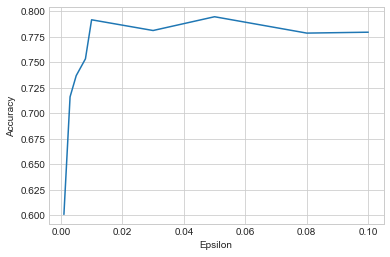

In [29]:
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.plot(epsilons, accs);

The plot shows that very small values of $\epsilon$ result in far less accurate models. Keep in mind that the $\epsilon$ we specify in the plot is a *per-iteration* $\epsilon$, so the privacy cost is much higher after composition.

## Time Efficiency of Differential Privacy

In a situation where the application of differential privacy is implemented as a direct loop over sensitive entities, there is a significant time cost incurred from the added burden of random number generation.

We can simulate and compare the runtime performance of two versions of a counting query - one with differential privacy, and one without it.

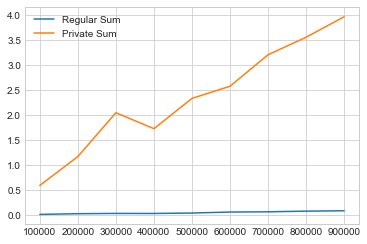

In [48]:
import itertools
import operator
import time

def time_count(k):   
    l = [1] * k
    start = time.perf_counter()
    itertools.accumulate(l, func=operator.add)
    stop = time.perf_counter()
    return stop - start 

def time_priv_count(k):  
    l = [1] * k
    start = time.perf_counter()
    itertools.accumulate(l, func=lambda x, y: x + laplace_mech(y,1,0.1), initial=0)
    stop = time.perf_counter()
    return stop - start 

x_axis = [k for k in range(100_000,1_000_000,100_000)]

plt.plot(x_axis, [time_count(k) for k in range(100_000,1_000_000,100_000)], label='Regular Count')

plt.plot(x_axis, [time_priv_count(k) for k in range(100_000,1_000_000,100_000)], label='Private Count')

plt.legend();

With the time spent counting on the y-axis, and the list lize on the x-axis, we can see that the time complexity of differential privacy for this particular operation is essentially linear in the size of the input.

The good news is that the above implementation of differentially private count is rather naive, and we can do much better using optimization techniques such as vectorization!

For example, when implementing differential privacy for the machine learning operations in this chapter, we make use of NumPy functions which are heavily optimized for vector-based operations. In this particular scenario, leveraging this strategy, we manage to incur negligible time cost for the use of differential privacy.

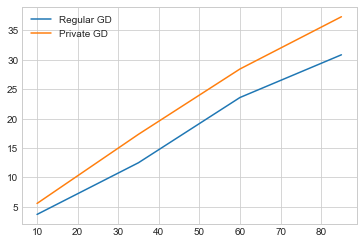

In [65]:
def time_gd(k):   
    start = time.perf_counter()
    gradient_descent(k)
    stop = time.perf_counter()
    return stop - start 

def time_priv_gd(k):   
    start = time.perf_counter()
    noisy_gradient_descent(k, 0.1, delta)
    stop = time.perf_counter()
    return stop - start 

x_axis = [k for k in range(10,100,25)]

plt.plot(x_axis, [time_gd(k) for k in range(10,100,25)], label='Regular GD')

plt.plot(x_axis, [time_priv_gd(k) for k in range(10,100,25)], label='Private GD')

plt.legend();

The graph plots generally overlap or are close in most simulations of this experiment, indicating low (constant) time inefficiency overhead incurred from utilizing private gradient descent.

## Space Efficiency of Differential Privacy

We can also analyze the space utilization of differential privacy mechanisms. In Python3 we can use a debug tool module to trace memory blocks allocated for use during evaluation. We may perform our analysis of space overhead by comparing the peak size of memory blocks used during private and non-private computation.

Following this strategy, we can measure the space overhead of the private count operation as follows:


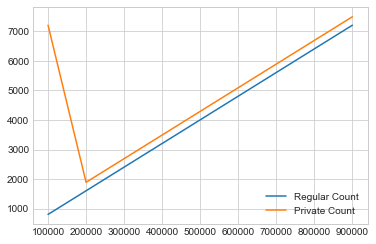

In [60]:
import itertools
import operator
import tracemalloc
 
tracemalloc.start()

def space_count(k):   
    l = [1] * k
    itertools.accumulate(l, func=operator.add)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    return peak/1000 

def space_priv_count(k):  
    l = [1] * k
    itertools.accumulate(l, func=lambda x, y: x + laplace_mech(y,1,0.1), initial=0)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    return peak/1000

x_axis = [k for k in range(100_000,1_000_000,100_000)]

plt.plot(x_axis, [space_count(k) for k in range(100_000,1_000_000,100_000)], label='Regular Count')

plt.plot(x_axis, [space_priv_count(k) for k in range(100_000,1_000_000,100_000)], label='Private Count')

tracemalloc.stop()

plt.legend();

We display every thousand memory blocks on the y-axis, against the list size on the x-axis. 

In this case, the memory complexity of differential privacy is generally constant.

We also observe a spike in the initial space cost for private count, which we can attribute to memory allocation of the random number generator resources.

We can repeat this experiment to contrast private and non-private machine learning:

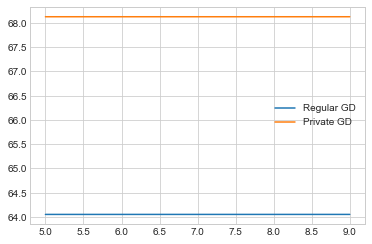

In [64]:
tracemalloc.start()

def space_gd(k):   
    gradient_descent(k)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    return peak/1_000_000 

def space_priv_gd(k):   
    noisy_gradient_descent(k, 0.1, delta)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    return peak/1_000_000

x_axis = [k for k in range(5,10,2)]

plt.plot(x_axis, [space_gd(k) for k in range(5,10,2)], label='Regular GD')

plt.plot(x_axis, [space_priv_gd(k) for k in range(5,10,2)], label='Private GD')

tracemalloc.stop()

plt.legend();

In this case the memory allocation is generally much larger - as expected - and we graph against every millionth allocated memory block. 

We also observe generally constant space overhead during private gradient descent.